In [28]:
import pandas as pd
import numpy as np

from run_backtest import load_trackers
from utils import clean_stale_prices

from entities import EM_CDS_TRACKER_DICT, FX_TRACKER_DICT
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [44]:
cds = load_trackers(EM_CDS_TRACKER_DICT).rename(columns=lambda col: col + "_cds")
fx = load_trackers(FX_TRACKER_DICT).rename(columns=lambda col: col + "_fx")

cds = pd.concat([clean_stale_prices(cds[col].copy()) for col in cds], axis=1)
fx = pd.concat([clean_stale_prices(fx[col].copy()) for col in fx], axis=1)

In [123]:
RETURN_WINDOW = 21

df_cds = (
    np.log(cds)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_cds = df_cds.loc["2009-12-10":].dropna(how="any", axis=1)
# df_cds.isna().sum(axis=1).plot()
# plt.title("Number of missing values - CDS")
df_fx = (
    np.log(fx)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_fx = df_fx.loc["2004-08-02":].dropna(how="any", axis=1)
# df_fx.isna().sum(axis=1).plot()
# plt.title("Number of missing values - CDS")

new_index = df_fx.dropna().index.intersection(df_cds.dropna().index)
df_fx = df_fx.reindex(new_index)
df_cds = df_cds.reindex(new_index)

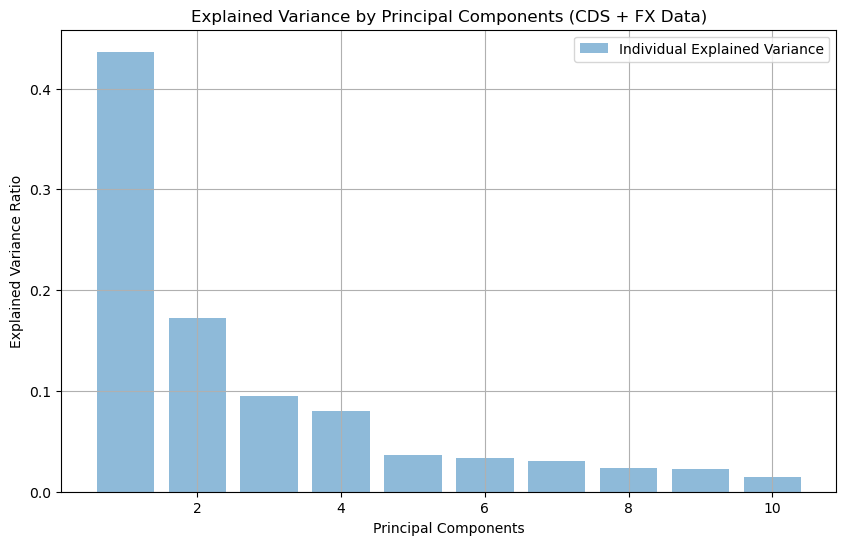

In [139]:
pca_cds_fx = PCA(n_components=10).fit(pd.concat([df_cds, df_fx], axis=1).dropna())
explained_variance_ratio = pca_cds_fx.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.5,
    align="center",
    label="Individual Explained Variance",
)
# plt.step(
#     range(1, len(cumulative_explained_variance) + 1),
#     cumulative_explained_variance,
#     where="mid",
#     label="Cumulative Explained Variance",
# )
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components (CDS + FX Data)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

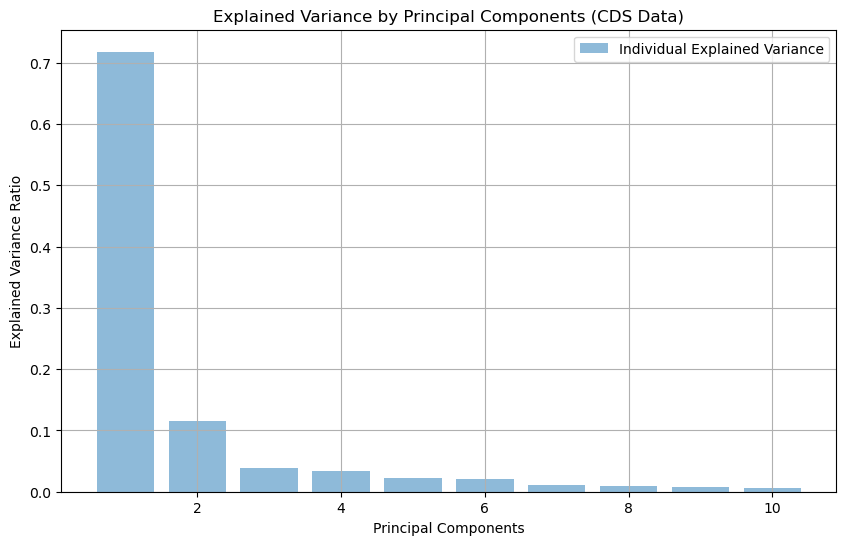

In [124]:
pca_cds = PCA(n_components=10).fit(df_cds.dropna())
explained_variance_ratio = pca_cds.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.5,
    align="center",
    label="Individual Explained Variance",
)
# plt.step(
#     range(1, len(cumulative_explained_variance) + 1),
#     cumulative_explained_variance,
#     where="mid",
#     label="Cumulative Explained Variance",
# )
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components (CDS Data)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

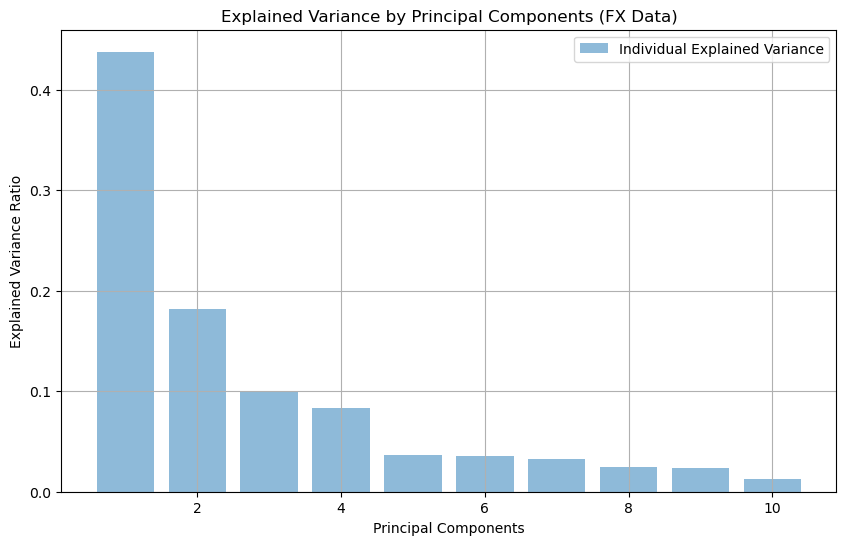

In [125]:
pca_fx = PCA(n_components=10).fit(df_fx.dropna())
explained_variance_ratio = pca_fx.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.5,
    align="center",
    label="Individual Explained Variance",
)
# plt.step(
#     range(1, len(cumulative_explained_variance) + 1),
#     cumulative_explained_variance,
#     where="mid",
#     label="Cumulative Explained Variance",
# )
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components (FX Data)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [135]:
pca_1_cds.corr(pca_1_fx)

0.7420601856915862

(0.0, 1.0)

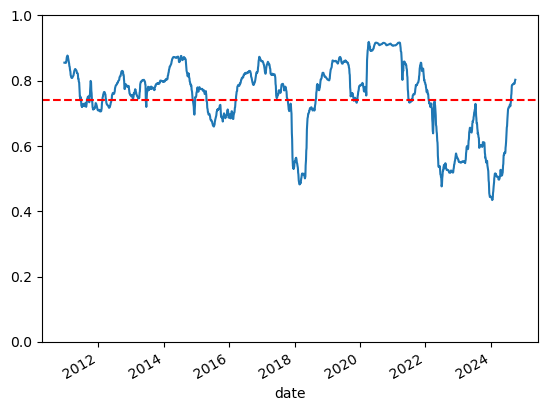

In [138]:
pca_1_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 0]
pca_1_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 0]

pca_1_cds.rolling(window=252).corr(pca_1_fx).plot()
plt.axhline(pca_1_cds.corr(pca_1_fx), color="r", linestyle="--")
plt.ylim(0, 1)

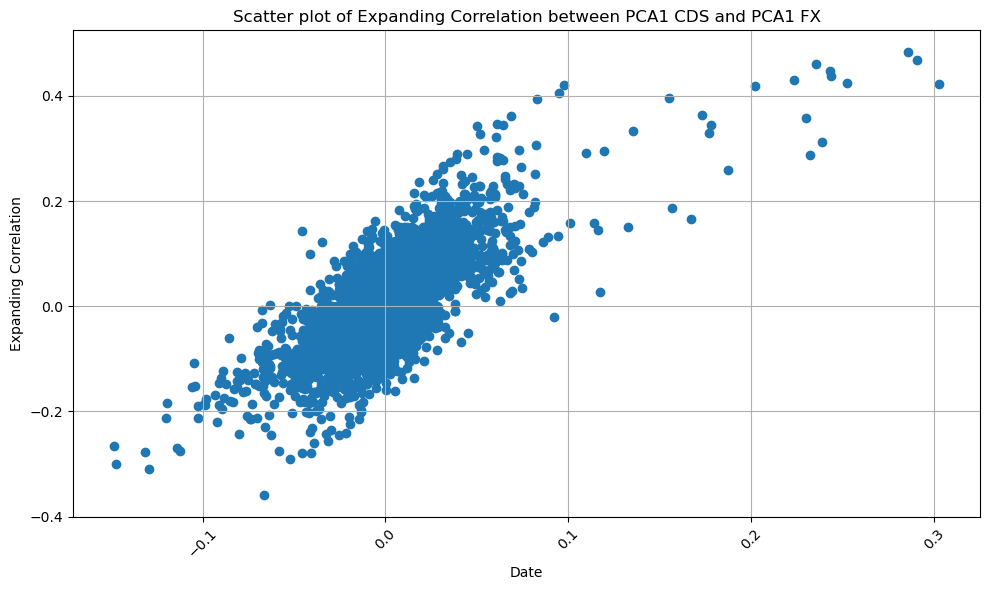

In [122]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_1_cds, pca_1_fx.reindex(pca_1_cds.index))
plt.title("Scatter plot of Expanding Correlation between PCA1 CDS and PCA1 FX")
plt.xlabel("Date")
plt.ylabel("Expanding Correlation")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

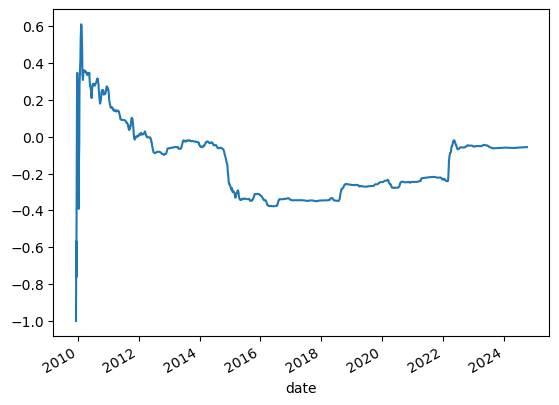

In [118]:
pca_2_fx = pd.DataFrame(
    pca_fx.fit_transform(df_fx.dropna()), index=df_fx.dropna().index
).iloc[:, 1]
pca_2_cds = pd.DataFrame(
    pca_cds.fit_transform(df_cds.dropna()), index=df_cds.dropna().index
).iloc[:, 1]

pca_2_cds.expanding().corr(pca_2_fx).dropna().plot()